In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder

## Preparing the Data

In [2]:
# Looking into the directory
data_dir = '/Users/kartik/Desktop/ScienceFairCode/data/archive-eyes'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/test")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

['test', 'train']
Train Classes - ['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']
Validation Classes - ['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']


In [3]:
# Data transforms (Gray Scaling & data augmentation)
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor()])

valid_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

In [4]:
# Emotion Detection datasets
train_ds = ImageFolder(data_dir + '/train', train_tfms)
valid_ds = ImageFolder(data_dir + '/test', valid_tfms)

In [5]:
batch_size = 200

In [6]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, pin_memory=True)

## Using a GPU

Tranfering the model and data to the 'cuda', if available

In [7]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [8]:
device = get_default_device()
device

device(type='cpu')

In [9]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Training Steps Creation

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

## Model Creation

In [11]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.input = conv_block(in_channels, 64)

        self.conv1 = conv_block(64, 64, pool=True)
        self.res1 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv2 = conv_block(64, 64, pool=True)
        self.res2 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(64, 64, pool=True)
        self.res3 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(64, num_classes))
        
    def forward(self, xb):
        out = self.input(xb)

        out = self.conv1(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        return self.classifier(out)

In [12]:
model = to_device(ResNet(1, len(classes_train)), device)
model

ResNet(
  (input): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )

## Training the model


In [13]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [14]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.9470999240875244, 'val_acc': 0.1227777823805809}]

In [15]:
epochs = 30
max_lr = 0.001
grad_clip = 0.2
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [16]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                        grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.00007, train_loss: 3.6140, val_loss: 2.2263, val_acc: 0.1189
Epoch [1], last_lr: 0.00015, train_loss: 2.1459, val_loss: 1.8854, val_acc: 0.2389
Epoch [2], last_lr: 0.00028, train_loss: 1.8944, val_loss: 1.8818, val_acc: 0.2253
Epoch [3], last_lr: 0.00044, train_loss: 1.8416, val_loss: 1.8551, val_acc: 0.2328
Epoch [4], last_lr: 0.00060, train_loss: 1.8014, val_loss: 1.8668, val_acc: 0.2708
Epoch [5], last_lr: 0.00076, train_loss: 1.7672, val_loss: 1.7786, val_acc: 0.2976
Epoch [6], last_lr: 0.00089, train_loss: 1.7300, val_loss: 1.8643, val_acc: 0.2797
Epoch [7], last_lr: 0.00097, train_loss: 1.7097, val_loss: 1.9075, val_acc: 0.2794
Epoch [8], last_lr: 0.00100, train_loss: 1.6905, val_loss: 1.7507, val_acc: 0.3225
Epoch [9], last_lr: 0.00099, train_loss: 1.6743, val_loss: 1.7874, val_acc: 0.3008
Epoch [10], last_lr: 0.00098, train_loss: 1.6575, val_loss: 1.7899, val_acc: 0.3027
Epoch [11], last_lr: 0.00095, train_loss: 1.6378, val_loss: 1.6648, val_acc: 0.3691
Ep

## Plotting Performance Graphs of the Model

In [17]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

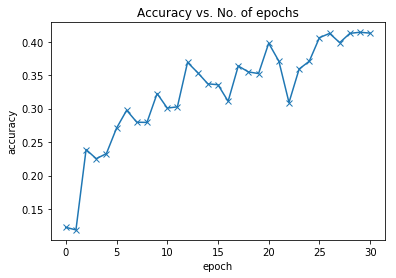

In [18]:
plot_accuracies(history)

In [19]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

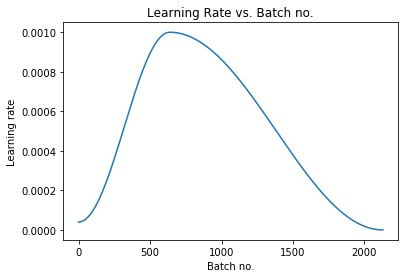

In [20]:
plot_lrs(history)

## Saving the Model



In [ ]:
# torch.save(model.state_dict(), './models/emotion_detection_model_state.pth')